In [1]:
%matplotlib qt

In [264]:
import random
import time

from mne.time_frequency import psd_multitaper
from mne import find_events, write_events
from mne.io import RawArray

import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import rteeg

In [265]:
stream.recording_duration() / 60

19.727566666666668

In [297]:
data = stream._get_raw_eeg_data()
events = stream.make_events(data)
print events.shape
data[-1,:] = 0
raw = RawArray(data, stream.info)
raw.add_events(events)

(203, 3)


In [303]:
events = find_events(raw, shortest_event=0)

In [304]:
write_events("rteeg_test_Dec8-events.fif", events)

In [281]:
raw.info['events'] = dict()

In [288]:
find_events(raw, shortest_event=0).shape

(0, 3)

In [283]:
raw.save('rteeg_test_Dec8-raw.fif', overwrite=True)

In [159]:
find_events(raw, shortest_event=0)

(881, 3)

In [3]:
stream = rteeg.Stream()

In [140]:
stream.recording_duration()

707.732

In [4]:
stream.connect(eeg=True, markers=True, eeg_montage='Enobio32')

Searching for EEG stream ... 
Searching for Markers stream ... 
Connected to EEG stream. 


In [147]:
raw = stream.make_raw()
# raw.plot()
print find_events(raw)

[]


In [16]:
stream.fit_ica(20)

[....................................... ] 99.95000 | Collecting data   
Computing ICA solution ...
Finished in 3.51 s


<ICA  |  raw data decomposition, fit (extended-infomax): 10000 samples, 32 components, channels used: "eeg">

In [148]:
epochs = stream.make_epochs()

[[181386      0      1]
 [183886      0      2]
 [186386      0      3]
 [188886      0      4]
 [191386      0      5]
 [193886      0      6]
 [196386      0      7]
 [198886      0      8]
 [201386      0      9]
 [203886      0     10]
 [206386      0     11]
 [208886      0     12]
 [211386      0     13]
 [213886      0     14]
 [216386      0     15]
 [218886      0     16]
 [221386      0     17]
 [223886      0     18]
 [226386      0     19]
 [228886      0     20]
 [231386      0     21]
 [233886      0     22]
 [236386      0     23]
 [238886      0     24]
 [241386      0     25]
 [243886      0     26]
 [246386      0     27]
 [248886      0     28]
 [251386      0     29]
 [253886      0     30]
 [256386      0     31]
 [258886      0     32]
 [261386      0     33]
 [263886      0     34]
 [266386      0     35]
 [268886      0     36]
 [271386      0     37]
 [273886      0     38]
 [276386      0     39]
 [278886      0     40]
 [281386      0     41]
 [283886      0 

[]


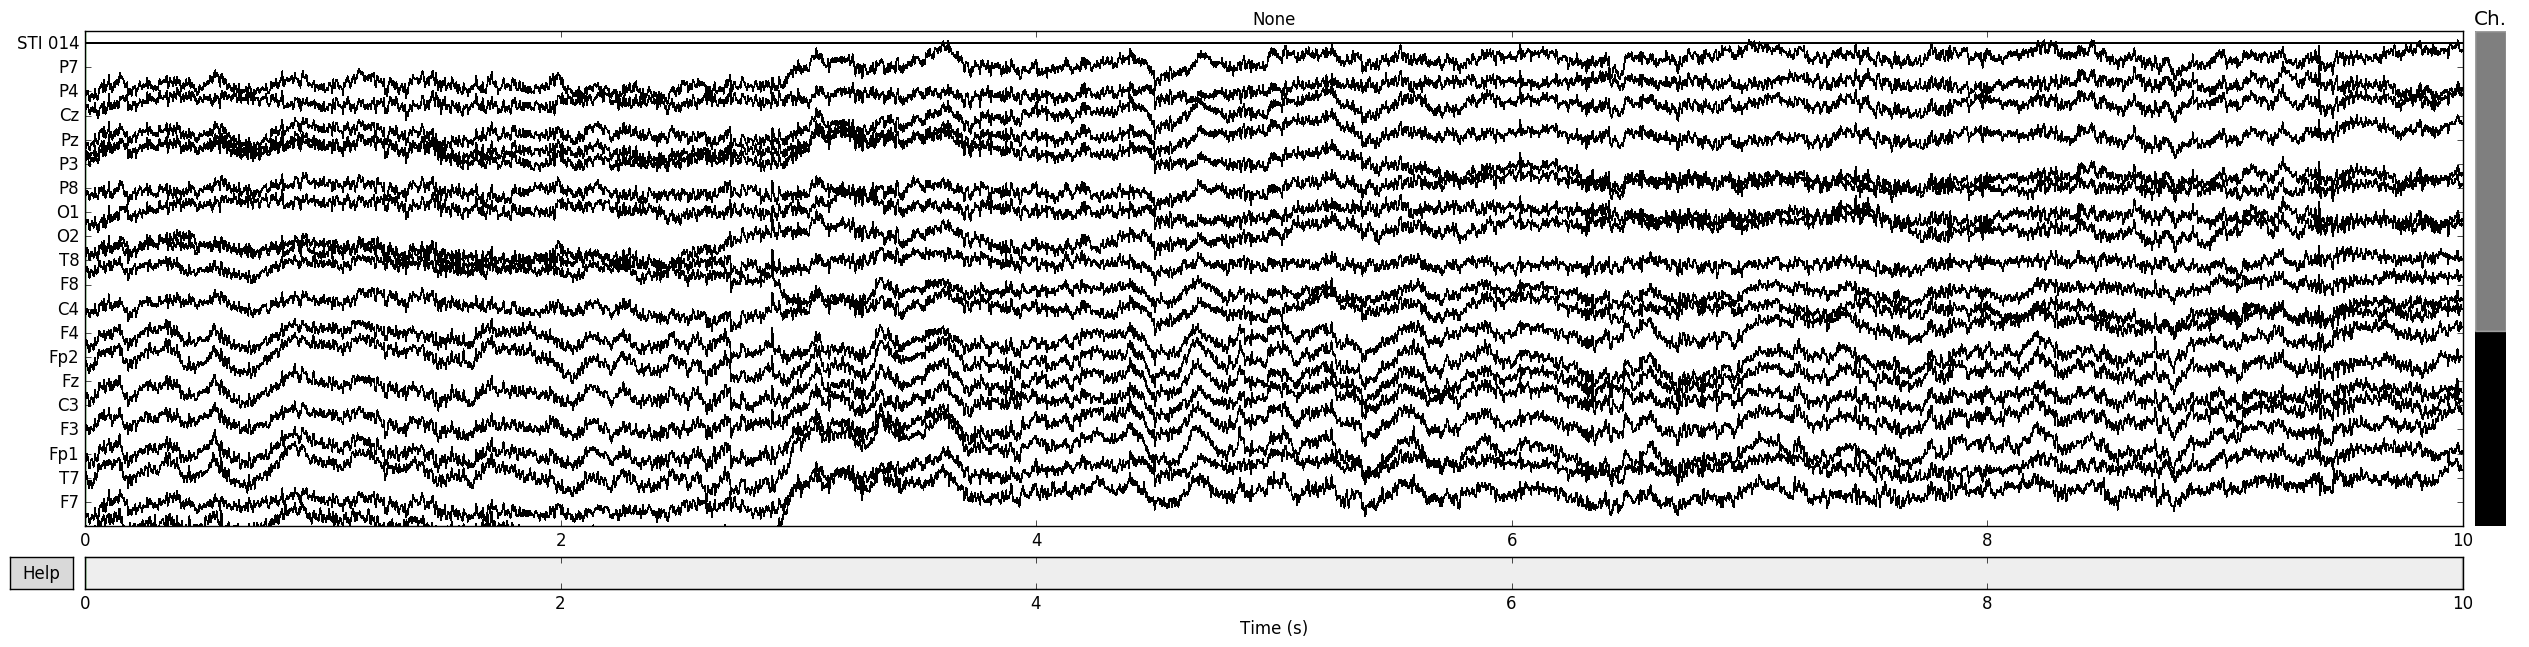

In [43]:
raw = stream.make_raw(10)
events = find_events(raw)
print events
raw.plot(events=events)

In [ ]:
predictions = []
these_times = []

def analysis_func(list_, global_times):
    output_base = """
    <head>
        <style>
        table {{font-size: 30px;}}
        th, td {{
            background-color: white;
            text-align: center;
            padding: 20px;
        }}

        </style>
    </head>
    <body>

        <table align="center">
            <tr>
                <th>Prediction</th>
                <th>EEG samples (N)</th>
                <th>Time since last prediction</th>
                <th>Analysis time (s)</th>
                <th>i</th>
            </tr>
            <tr>
                <td style="background-color:{color}"><b>{prediction}</b></td>
                <td>{n_samples}</td>
                <td>{t_delta_main:.4f}</td>
                <td>{t_delta:.4f}</td>
                <td>{i}</td>
            </tr>
        </table>

    </body>
    """
    n_samples = len(stream._eeg_data)
    event_id = {
        1: ["Class 1", "green"],
        2: ["Class 2", "red"],
    }

    y_pred = random.choice(event_id.keys())
    list_.append(y_pred)

    t0 = time.time()
    raw = stream.make_raw(10)
    raw.filter(1., 40)
    psd, freqs= psd_multitaper(raw, fmin=1., fmax=7.0)
    psd_scaled = StandardScaler().fit_transform(psd)
    pca = PCA(n_components=15).fit_transform(psd_scaled)
    t_delta = time.time() - t0
    
    if global_times:
        t1 = time.time()
        t_delta_main = t1 - global_times[-1]
        global_times.append(t1)
    else:
        global_times.append(time.time())
        t_delta_main = 0.
        
    out = output_base.format(prediction=event_id[y_pred][0],
                             color=event_id[y_pred][1],
                             n_samples=n_samples,
                             t_delta=t_delta,
                             t_delta_main=t_delta_main,
                             i=len(list_))
    t_delta_main = None
    
    return out

In [ ]:
a = rteeg.LoopAnalysis(stream, 1, analysis_func, (predictions, these_times), 
                       show_window=True)

In [ ]:
a.stop()